<a href="https://colab.research.google.com/github/Zshoham/FridgeVision/blob/main/FridgeVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preperation

Our goal in this project is to identify groceries in a picture of fridge
and suggest to the user what groceries he is lacking.

In this notebook we will attempt to build a model that can recognize groceries in images. We combine a few data sets in order to train our model.

The first is the COCO image data set - https://cocodataset.org/#explore wich has 10 classes of food that we will use.

Second is Freiburg Groceries Dataset - https://github.com/PhilJd/freiburg_groceries_dataset/blob/master/README.md which has 25 classes of groceries in supermarket shelfs.

Another supermarket groceries dataset - https://github.com/eg4000/SKU110K_CVPR19 contains much images with much more objects and bounding boxes.

In [1]:
!pip install py7zr

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 13.7MB 315kB/s 


In [2]:
import requests
import os
import py7zr

FRIDGE_TRAIN = "fridge/data_fridge/data_fridge/Train"
FRIDGE_TEST = "fridge/data_fridge/data_fridge/Test"


if not os.path.isdir("fridge"):
  fridge_data = requests.get("https://drive.google.com/uc?export=download&id=1yXoDMSPodJb1xBprxplTWy9XwgJm9Mcl")
  with open("fridge.7z", 'wb') as f:
    f.write(fridge_data.content)
  
  zip = py7zr.SevenZipFile('fridge.7z', mode='r')
  zip.extractall("fridge")
  zip.close()

In [3]:
from PIL import Image
import numpy as np
from sklearn.utils import shuffle


def generate_class_map(classes):
  maps = {
      "id-name": {},
      "name-id": {}
  }
  for i in range(len(classes)):
    maps["name-id"][classes[i]] = i
    maps["id-name"][i] = classes[i]
  
  return maps

def load_dataset(data_path):
  data = []
  labels = []
  classes = os.listdir(data_path)
  cls_map = generate_class_map(classes)
  for cls in classes:
    for img_path in os.listdir(data_path + "/" + cls):
      img = Image.open(data_path + "/" + cls + "/" + img_path)
      img = img.resize((224, 224))
      data.append(np.array(img))
      labels.append(cls_map["name-id"][cls])

  data = np.array(data)
  labels = np.array(labels)
  data, labels = shuffle(data, labels)

  return data, labels, cls_map

# Data Exploration

In [ ]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

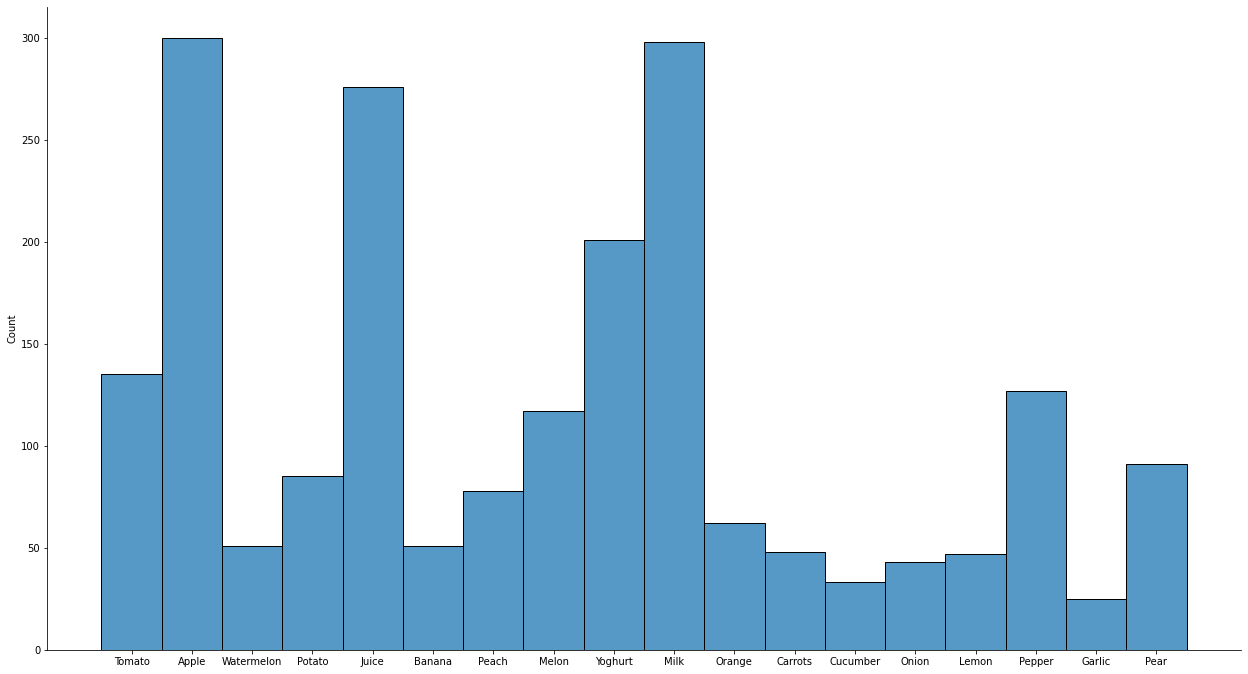

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_label_names = np.array([cls_map["id-name"][id] for id in train_labels])
test_label_names = np.array([cls_map["id-name"][id] for id in test_labels])

f = sns.displot(train_label_names)
f.fig.set_figwidth(20)
f.fig.set_figheight(10)

As we can see the data is very imbalanced, and in general we do not have many examples of even the more popular classes, to combat this we are going to apply data augmentation selectevly, in such a way that the less examples the class has, the more augmentations it will recieve.

# Model Evaluation

In [11]:
!pip install wandb -qqq
!wandb login
import os
os.environ['WANDB_CONSOLE'] = "off"
os.environ['WANDB_SILENT'] = "true"

     |████████████████████████████████| 1.8MB 4.3MB/s 
     |████████████████████████████████| 163kB 40.8MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 133kB 32.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

def calculate_scores(true_values, pred_values):
  acc = accuracy_score(true_values, pred_values)
  f1 = f1_score(true_values, pred_values, average='macro')

  return [
      ("accuracy", acc),
      ("f1 score", f1)
  ]

def eval_classifier(name, model_gen,
                    training_data, testing_data,
                    config):
  print("----------------------------------------")
  print(f"evaluating {name} model")
  print("----------------------------------------")

  train_data, train_labels = training_data
  test_data, test_labels = testing_data

  kf = KFold(n_splits=10)
  fold_num = 1

  for train_index, val_index in kf.split(train_data):
    x_train = train_data[train_index]
    y_train = train_labels[train_index]

    x_val = train_data[val_index]
    y_val = train_labels[val_index]

    wandb.init(
        project="FridgeVision",
        group=name,
        name=name + "-fold-" + str(fold_num),
        config=config
    )

    model = model_gen()

    model.fit(x_train, y_train,
              batch_size=config['batch_size'], epochs=config['epochs'],
              validation_data=(x_val, y_val),
              callbacks=[WandbCallback()])

    val_pred_probs = model.predict(x_val)
    val_pred = np.argmax(val_pred_probs, axis=1)
    val_scores = calculate_scores(y_val, val_pred)
  
    print("----------------------------------------")
    print(f"validation results for fold number {fold_num}:")
    for metric, score in val_scores:
      print(f"  {metric}: {score}")
    print()

    test_pred_probs = model.predict(test_data)
    test_pred = np.argmax(test_pred_probs, axis=1)
    test_scores = calculate_scores(test_labels, test_pred)

    print("----------------------------------------")
    print(f"test results for fold number {fold_num}:")
    for metric, score in test_scores:
      print(f"  {metric}: {score}")
    print()

    wandb.log({"validation " + metric: score for (metric, scor) in val_scores}, commit=False)
    wandb.log({"test " + metric: score for (metric, scor) in test_scores}, commit=False)
    wandb.log({"validation confusion matrix": wandb.plot.confusion_matrix(val_pred, y_val, list(cls_map["id-name"].values()))})
    wandb.log({"test confusion matrix": wandb.plot.confusion_matrix(test_pred, test_labels, list(cls_map["id-name"].values()))})
    fold_num += 1
        

# Data Augmentation

In [4]:
import imgaug.augmenters as iaa
import imgaug as ia
from sklearn.utils import shuffle

flip = iaa.Fliplr(1.0)

rotate = iaa.Affine(rotate=(-45, 45), mode="edge")

trans = iaa.OneOf([
    iaa.Affine(translate_percent={"x": (-0.2, 0.2)}, mode="edge"),
    iaa.Affine(translate_percent={"y": (-0.2, 0.2)}, mode="edge")
])

huesat = iaa.AddToHueAndSaturation((-30, 30), per_channel=True)

gamma = iaa.GammaContrast([0.5,2.0])

noise = iaa.AdditiveGaussianNoise(scale=(0, 0.15*255), per_channel=True)

blur = iaa.GaussianBlur(sigma=(0.0, 2.0))

re_medium = iaa.KeepSizeByResize(iaa.Crop((100, 140), keep_size=False))
re_large = iaa.KeepSizeByResize(iaa.Crop((160, 200), keep_size=False))



def apply_aug(data, labels, augs):
  cps = [np.copy(data) for i in range(len(augs))]
  aug_data = np.concatenate([augs[i](images=cps[i]) for i in range(len(augs))])
  aug_labels = np.concatenate([labels for i in range(len(augs))])
  return aug_data, aug_labels

def augment_by_dist(data, labels):
  classes, class_counts = np.unique(labels, return_counts=True)
  min_count = class_counts.min()
  max_count = class_counts.max()

  jmp = (max_count - min_count) / 3 
  lower_filter = min_count + jmp
  mid_filter = min_count + 2*jmp

  aug_data = data
  aug_labels = labels

  for cls in classes:
    cls_labels = labels == cls
    count_cls_labels = len(cls_labels)
    cls_labels = labels[cls_labels]
    cls_data = data[cls_labels]

    aug_cls_data_4, aug_cls_labels_4 = apply_aug(cls_data, cls_labels, [re_medium, re_large])
    aug_data = np.concatenate((aug_data, aug_cls_data_4))
    aug_labels = np.concatenate((aug_labels, aug_cls_labels_4))

    if count_cls_labels > lower_filter:
      aug_cls_data_6, aug_cls_labels_6 = apply_aug(cls_data, cls_labels, [flip, rotate, trans])
      aug_data = np.concatenate((aug_data, aug_cls_data_6))
      aug_labels = np.concatenate((aug_labels, aug_cls_labels_6))

    if count_cls_labels > mid_filter:
      aug_cls_data_8, aug_cls_labels_8 = apply_aug(cls_data, cls_labels, [huesat, gamma, noise, blur])
      aug_data = np.concatenate((aug_data, aug_cls_data_8))
      aug_labels = np.concatenate((aug_labels, aug_cls_labels_8))

  return shuffle(aug_data, aug_labels)

# EfficientNetB0

In [5]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import EfficientNetB0, efficientnet

effnet_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b0',
    "batch_size": 10,
    "epochs": 5
}

def effnet_gen():
  core = EfficientNetB0(include_top=False, input_shape=(224,224,3))

  core.trainable = False

  input = keras.Input(shape=(None, None, 3))
  x = layers.experimental.preprocessing.Resizing(224, 224)(input)

  x = core(x, training=False)
  x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(25, activation="softmax")(x)
  model = tf.keras.Model(input, outputs, name="EfficientNet")
  model.compile(optimizer=effnet_config["optimizer"], loss=effnet_config["loss"], metrics=['accuracy'])
  return model

effnet_gen().summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_______________________________________________________

## Without Augmentation

In [ ]:
train_data = efficientnet.preprocess_input(train_data)
test_data = efficientnet.preprocess_input(test_data)
eval_classifier("effnet", effnet_gen,
                (train_data, train_labels),
                (test_data, test_labels),
                effnet_config)

## With Augmentation

In [13]:
effnet_aug_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b0',
    "batch_size": 100,
    "epochs": 20
}

train_data_aug, train_labels_aug = augment_by_dist(train_data, train_labels)
train_data_aug = efficientnet.preprocess_input(train_data_aug)
test_data = efficientnet.preprocess_input(test_data)
eval_classifier("effnet-aug", effnet_gen,
                (train_data_aug, train_labels_aug),
                (test_data, test_labels),
                effnet_aug_config)

----------------------------------------
evaluating effnet-aug model
----------------------------------------
Epoch 1/20
  6/187 [..............................] - ETA: 17:25 - loss: 4.3171 - accuracy: 0.0829

KeyboardInterrupt: ignored

# EfficientNetB3

In [ ]:
train_data, train_labels, cls_map = load_dataset(FRIDGE_TRAIN)
test_data, test_labels, _ = load_dataset(FRIDGE_TEST)

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import EfficientNetB3, efficientnet

effnetb3_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b3',
    "batch_size": 10,
    "epochs": 5
}

def effnetb3_gen():
  core = EfficientNetB3(include_top=False, input_shape=(224,224,3))

  core.trainable = False

  input = keras.Input(shape=(None, None, 3))
  x = layers.experimental.preprocessing.Resizing(224, 224)(input)

  x = core(x, training=False)
  x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(25, activation="softmax")(x)
  model = tf.keras.Model(input, outputs, name="EfficientNetB3")
  model.compile(optimizer=effnetb3_config["optimizer"], loss=effnetb3_config["loss"], metrics=['accuracy'])
  return model

effnetb3_gen().summary()

Model: "EfficientNetB3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1536)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1536)              6144      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)             

## Without Augmentation

In [ ]:
train_data = efficientnet.preprocess_input(train_data)
test_data = efficientnet.preprocess_input(test_data)
eval_classifier("effnetb3", effnet_gen,
                (train_data, train_labels),
                (test_data, test_labels),
                effnet_config)

## With Augmentation

In [ ]:
effnet_aug_config = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "effnet_scale": 'b0',
    "batch_size": 100,
    "epochs": 20
}

train_data_aug, train_labels_aug = augment_by_dist(train_data, train_labels)
train_data_aug = efficientnet.preprocess_input(train_data_aug)
test_data = efficientnet.preprocess_input(test_data)
eval_classifier("effnet-aug", effnet_gen,
                (train_data_aug, train_labels_aug),
                (test_data, test_labels),
                effnet_aug_config)

# Testing

In [ ]:
_, _ = augment_by_dist(train_data, train_labels)

hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey


KeyboardInterrupt: ignored

In [ ]:
model = model_gen()
model.fit(train_data, train_labels, batch_size=20, epochs=20, validation_data=(test_data, test_labels))

Epoch 1/20
104/104 [==============================] - 12s 77ms/step - loss: 2.5172 - accuracy: 0.3851 - val_loss: 0.7968 - val_accuracy: 0.8321
Epoch 2/20
104/104 [==============================] - 7s 66ms/step - loss: 0.3884 - accuracy: 0.8769 - val_loss: 0.4465 - val_accuracy: 0.8752
Epoch 3/20
104/104 [==============================] - 7s 66ms/step - loss: 0.2030 - accuracy: 0.9234 - val_loss: 0.3396 - val_accuracy: 0.8934
Epoch 4/20
104/104 [==============================] - 7s 66ms/step - loss: 0.1468 - accuracy: 0.9532 - val_loss: 0.3108 - val_accuracy: 0.8934
Epoch 5/20
104/104 [==============================] - 7s 66ms/step - loss: 0.1290 - accuracy: 0.9562 - val_loss: 0.3056 - val_accuracy: 0.8979
Epoch 6/20
104/104 [==============================] - 7s 66ms/step - loss: 0.0855 - accuracy: 0.9735 - val_loss: 0.3016 - val_accuracy: 0.9053
Epoch 7/20
104/104 [==============================] - 7s 66ms/step - loss: 0.0776 - accuracy: 0.9712 - val_loss: 0.3044 - val_accuracy: 0.901

In [ ]:
test_label_names = [name_map[lbl_id] for lbl_id in testing_labels]

In [ ]:
test_id = 0
for i in range(len(testing_data)):
  img = Image.fromarray(testing_data[i])
  label = test_label_names[i]
  img.save("test/" + label + "/" + label + "_" + str(test_id) + ".jpg")
  test_id += 1

In [ ]:
train_label_names = [name_map[lbl_id] for lbl_id in training_labels]

In [ ]:
train_id

22275

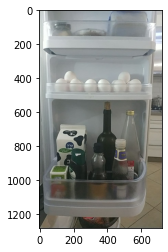

In [ ]:
import matplotlib.pyplot as plt

img = Image.open("download.jpg") 
img = img.convert("RGB")
milk = np.array(img)
plt.imshow(milk)

In [ ]:
milk.shape

(720, 1280, 3)

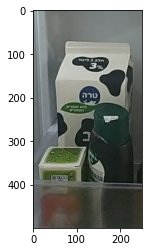

In [ ]:
plt.imshow(milk[600:1100, 50:300])

In [ ]:
milk = np.array([milk[600:1100, 50:300]])

In [ ]:
milk.shape

(1, 500, 250, 3)

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(wandb.restore("model-best.h5", run_path="/zshoham/FridgeVision/vwjigbmr").name)
best_model.trainable = False
model = tf.keras.Model(best_model.input, best_model.output, name="Best")
model.summary()

Model: "Best"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                32025  

In [ ]:

probs = model.predict(milk)
print(probs)
print(np.argmax(probs, axis=1))

[[9.8163468e-01 7.3412363e-03 2.1092632e-05 9.8012367e-07 4.0505675e-04
  1.2116152e-07 4.5598161e-05 1.7905360e-04 1.6180836e-04 4.3613531e-06
  5.9270893e-05 5.2584743e-04 8.7633714e-05 3.2550929e-08 2.3265410e-04
  1.8578225e-04 1.1322107e-03 7.9365661e-03 2.4387020e-05 2.7806623e-06
  7.0261885e-06 4.7515373e-06 4.1887160e-06 2.0881428e-06 7.7455604e-07]]
[0]


In [ ]:
cls_map["id-name"][0]

'Milk'

In [ ]:
cls_map["name-id"]['Pepper']

8

In [ ]:
probs[0][8]

0.17623538